In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/luciano/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


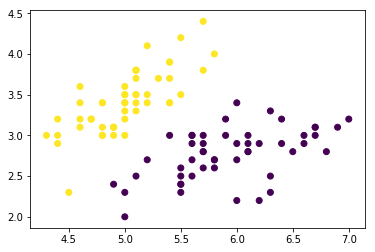

In [3]:
def get_iris():
    data = pd.read_csv("../data/iris/iris.data", header=None)
    
    data_filtered = data[data[4].isin(['Iris-setosa', 'Iris-versicolor'])]
    data_filtered[4] = data_filtered[4].apply(lambda x: 1 if x == 'Iris-setosa' else -1)
    
    data_array = data_filtered.values
    X = data_array[:, :2]
    y = data_array[:, 4]
    
    return X, y

X_iris, y_iris = get_iris()
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris)

In [4]:
data = pd.read_csv("../data/housing/housing.data", header=None)
data = data[[2, 3, 4, 7, 8, 9, 11]]
X_housing = data.values
y_housing = data.apply(lambda x: 2*(x[2] + x[3] <= -85.7)-1, axis=1)
(y_housing == 1).sum()/len(y_housing)

0.041860465116279069

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_housing_fit = scaler.fit_transform(X_housing)

In [6]:
def polygon(n_samples=100, add_noise=0, verbose=True):
    # data
    ths = np.linspace(0, 2*np.pi*(1-1.0/n_samples), n_samples)
    ths += np.random.normal(0,0.1)
    data = np.array([np.cos(ths), np.sin(ths)]).T
    
    if add_noise > 0:
        data = np.hstack([data, np.random.uniform(size=(len(data), add_noise))])
        
    # labels
    labels = 2*(data[:,0] > 0) - 1
    
    return data, labels

X_pol, y_pol = polygon(200)

In [7]:
# MUSHROOM dataset
data = pd.read_csv('../data/mushroom/mushroom.data')
y = data['p'].map(lambda x: 1 if x == 'e' else -1)
X = data.drop(['p', 'e.1', 'p.2'], axis=1)

# get H matrix
X_mush = pd.get_dummies(X).applymap(lambda x: 2*x-1).values
y_mush = y.values

In [8]:
# DERMATOLOGY dataset
data = pd.read_csv('../data/dermatology/dermatology.data').applymap(lambda x: str(x))
X = data.drop('2.3', axis=1)
y = data['2.3']

mask = y.isin(['1','2','3'])
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True).apply(lambda x: -1 if x == '2' else 1)

X_derm = (2.0*pd.get_dummies(X) - 1).values
y_derm = y.values

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C=10000, kernel='linear', max_iter=100000)
clf.fit(X_housing_fit,y_housing)
accuracy_score(clf.predict(X_housing_fit), y_housing)

1.0

    housing                                                              \
   accuracy                                                               
  linearSVM                                  random                       
        max      mean       min       std       max      mean       min   
3  0.875969  0.566047  0.131783  0.229134  0.886822  0.634496  0.141085   
4  0.965891  0.666744  0.213953  0.203240  0.936434  0.763411  0.537984   
5  0.959690  0.719380  0.310078  0.169570  0.947287  0.787752  0.537984   
6  0.976744  0.759612  0.513178  0.128479  0.947287  0.828527  0.618605   
7  0.986047  0.816977  0.662016  0.121022  0.973643  0.841938  0.665116   

                                   ...         iris                          \
                                   ...       recall                           
              solver5              ...    linearSVM           random          
        std       max      mean    ...          min       std    max   mean   
3  0.172

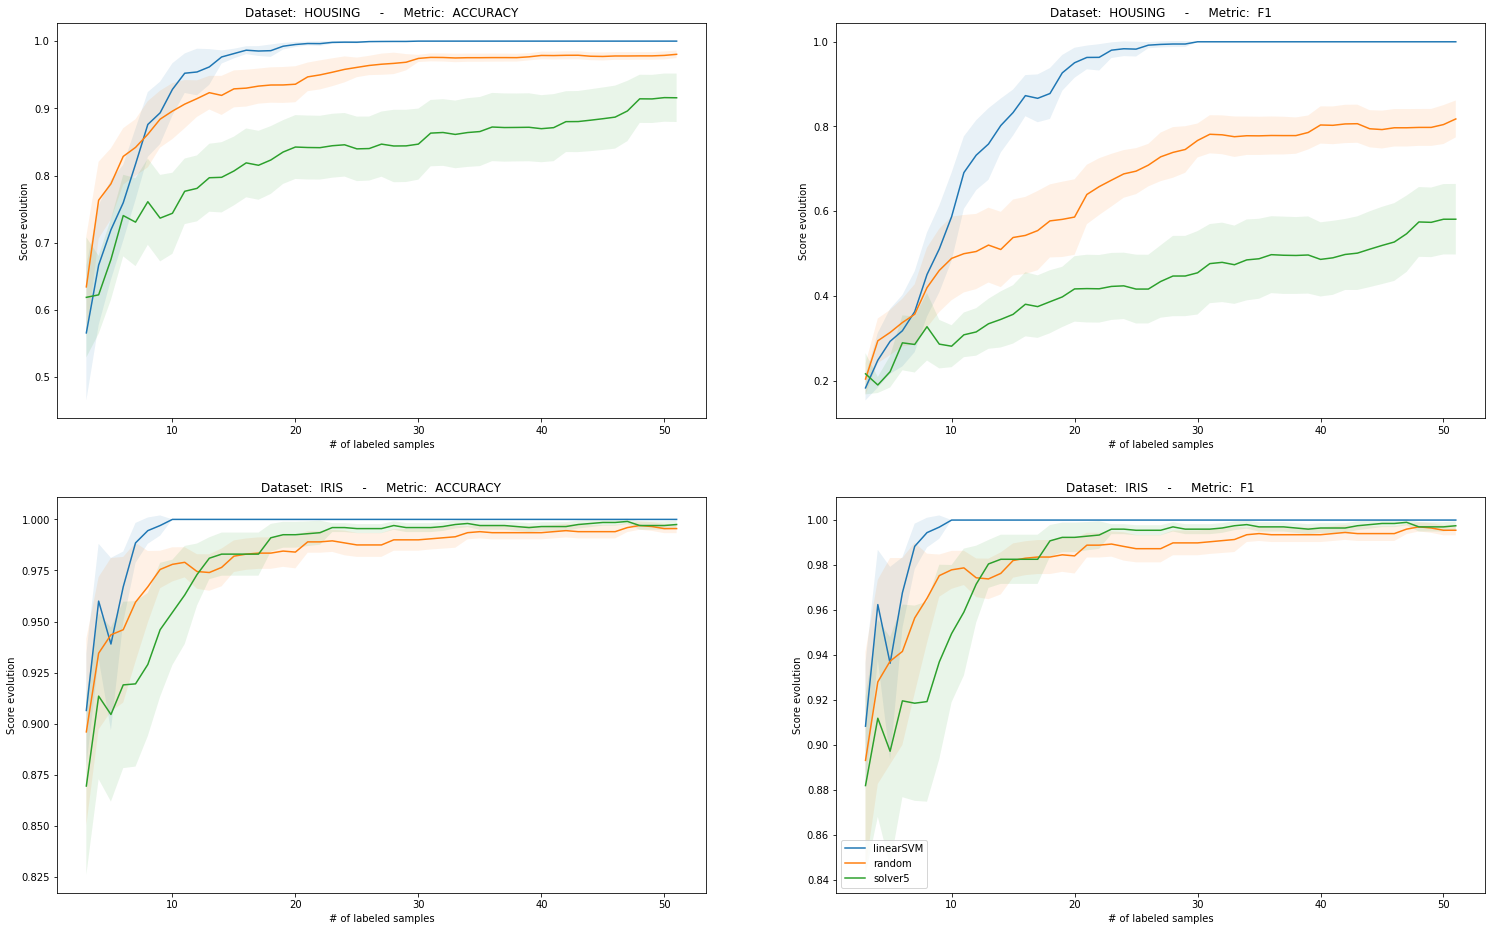

In [12]:
from src.user import DummyUser
from src.utils import Adaboost
from src.active_learning.boosting import QueryByBoosting, ActBoost
from src.active_learning.svm import SimpleMargin, SolverMethod
from src.active_learning.agnostic import RandomLearner
from src.active_learning.base import train
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import Showdown
from src.plotting import plot_showdown

max_iter = 50
user_housing = DummyUser(max_iter=max_iter, y_true=y_housing)
user_iris = DummyUser(max_iter=max_iter, y_true=y_iris)
user_pol = DummyUser(max_iter=max_iter, y_true=y_pol)
user_mush = DummyUser(y_true=y_mush, max_iter=max_iter)
user_derm = DummyUser(y_true=y_derm, max_iter=max_iter)

active_learners_list = [
     ("random", RandomLearner(SVC(C=1000, kernel='linear'))),
     ("linearSVM", SimpleMargin(C=1000, kernel='linear')),
     #("rbfSVM", SimpleMargin(C=1000, kernel='rbf')),
     ("solver5", SolverMethod(pool_size=5, C=1000, kernel='linear')),
     #("solver10", SolverMethod(pool_size=10, C=1000, kernel='linear')),
     #("solver20", SolverMethod(pool_size=20, C=1000, kernel='linear'))
     #("actboost", ActBoost(chain_length=50, sample_size=8, n_iterations=300)),
     #("random", RandomLearner(Adaboost(n_iterations=300))),
     #("qbb", QueryByBoosting(n_iterations=300)), 
]

datasets_list = [
    ("housing", X_housing_fit, user_housing),
    ("iris", X_iris, user_iris),
    #("polygon1", X_pol, user_pol),
    #("mushroom", X_mush, user_mush),
    #("dermatology", X_derm, user_derm)
]

times = 20
initial_sampler = FixedSizeStratifiedSampler(sample_size=2)
showdown = Showdown(times, initial_sampler)
output = showdown.run(datasets_list, active_learners_list)

print(output.head())
plot_showdown(output, times, metrics_list=['accuracy', 'f1'])